## The DaVinci Code

In [9]:
import os
import cv2
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
import pywt
from typing import Tuple
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle

In [11]:
def load_image(folder: str, filename: str, grayscale: bool = True) -> np.ndarray:
    """
    Load an image from the given folder and filename using OS-independent paths.

    Parameters:
    - folder: Directory containing the image
    - filename: Image filename (e.g., 'image1.png')
    - grayscale: Load as grayscale or color (default: True)

    Returns:
    - Loaded image as a NumPy array
    """
    path = os.path.join(folder, filename)
    flag = cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR
    image = cv2.imread(path, flag)
    if image is None:
        raise FileNotFoundError(f"Could not load image at path: {path}")
    return image

In [13]:
def plote_images(images: list[np.ndarray], titles: list[str] = None, cmap: str = 'gray', figsize: tuple = (10, 5)):
    """
    Display multiple images side by side with optional titles.

    Parameters:
    - images: List of NumPy arrays representing the images.
    - titles: Optional list of titles for each image.
    - cmap: Colormap to use (default: 'gray' for grayscale).
    - figsize: Tuple for figure size.
    """
    n = len(images)
    if titles is None:
        titles = [f"Image {i+1}" for i in range(n)]
    if len(titles) != n:
        raise ValueError("Number of titles must match number of images.")

    plt.figure(figsize=figsize)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [15]:
def plot_histogram(image: np.ndarray, title: str = "Normalized Intensity Histogram") -> None:
    """
    Plot normalized histogram of a grayscale image.
    
    Args:
        image (np.ndarray): Grayscale image.
        title (str): Title of the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(image.ravel(), bins=256, range=(0, 256), color='gray', density=True)
    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.show()

In [17]:
# Smoothing Filters
def denoise_box_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.blur(image, (ksize, ksize))

def denoise_gaussian_filter(image: np.ndarray, ksize: int = 5, sigma: float = 1.0) -> np.ndarray:
    return cv2.GaussianBlur(image, (ksize, ksize), sigma)

# Statistical Filters
def denoise_median_filter(image: np.ndarray, ksize: int = 5) -> np.ndarray:
    return cv2.medianBlur(image, ksize)

def denoise_max_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.dilate(image, np.ones((ksize, ksize), np.uint8))

def denoise_min_filter(image: np.ndarray, ksize: int = 3) -> np.ndarray:
    return cv2.erode(image, np.ones((ksize, ksize), np.uint8))

# Advanced Filters
def denoise_bilateral_filter(image: np.ndarray) -> np.ndarray:
    return cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)

def denoise_nl_means(image: np.ndarray, h: int = 10) -> np.ndarray:
    return cv2.fastNlMeansDenoising(image, None, h, 7, 21)

def denoise_wavelet_filter(image: np.ndarray) -> np.ndarray:
    return denoise_wavelet(image, channel_axis=None, convert2ycbcr=False, rescale_sigma=True)

def denoise_total_variation(image: np.ndarray, weight: float = 0.1) -> np.ndarray:
    return denoise_tv_chambolle(image, weight=weight, channel_axis=None)

#### image 1: Denoising

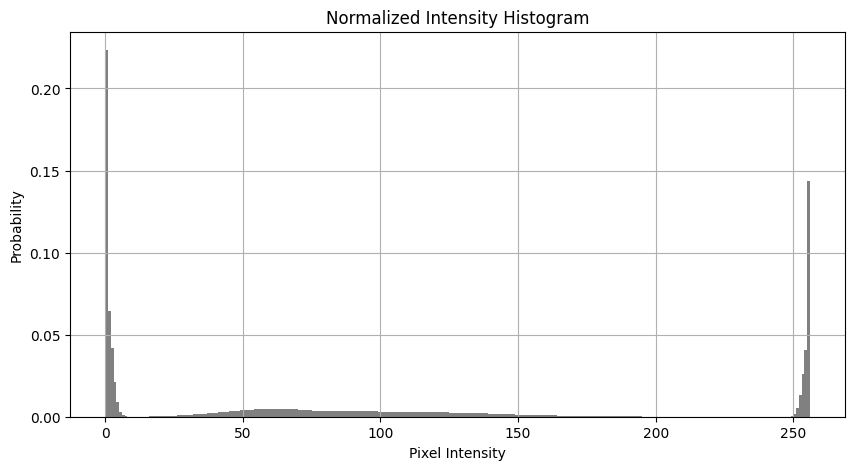

In [103]:
img1 = load_image("Q1", "processed_img_part_1.jpg")
plot_histogram(img1)

In [56]:
img_box = denoise_box_filter(img1)
img_box_larger = denoise_box_filter(img1, ksize = 15)
img_gaussian = denoise_gaussian_filter(img1)
img_gaussian_larger = denoise_gaussian_filter(img1, ksize = 15)

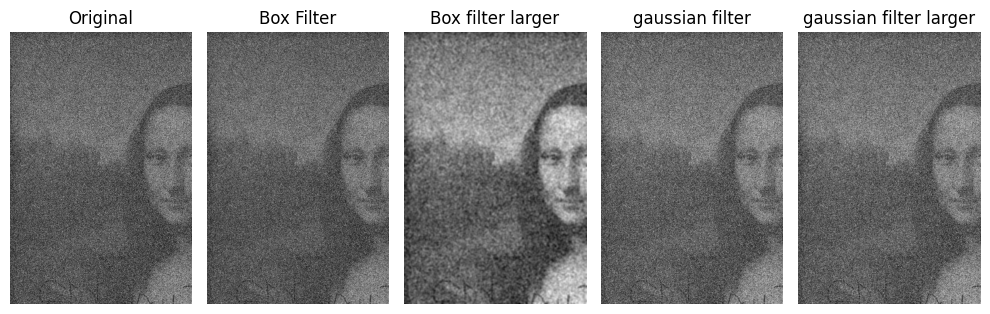

In [31]:
plote_images(
    [img1, img_box, img_box_larger, img_gaussian, img_gaussian_larger],
    titles=["Original", "Box Filter", "Box filter larger", "gaussian filter", "gaussian filter larger"]
)

In [33]:
img_bilateral = denoise_bilateral_filter(img1)
img_nlmeans = denoise_nl_means(img1)
img_wavelet = denoise_wavelet_filter(img1)
img_tv = denoise_total_variation(img1)

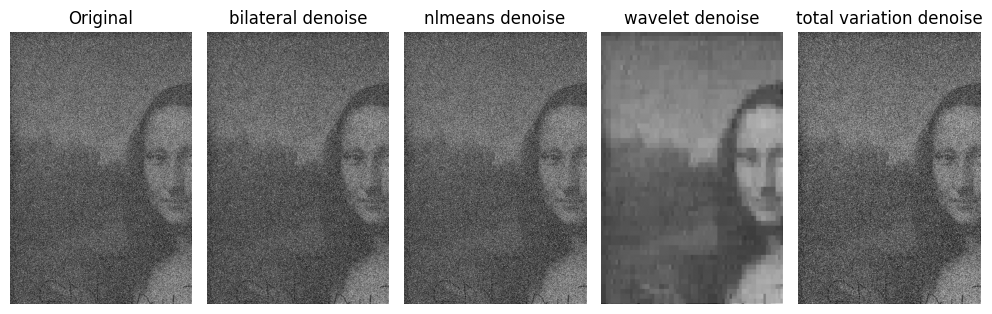

In [34]:
plote_images(
    [img1, img_bilateral, img_nlmeans, img_wavelet, img_tv],
    titles=["Original", "bilateral denoise", "nlmeans denoise", "wavelet denoise", "total variation denoise"]
)

In [37]:
img_max = denoise_max_filter(img1)
img_min = denoise_min_filter(img1)
img_median = denoise_median_filter(img1)
img_median_larger = denoise_median_filter(img1, ksize = 7)

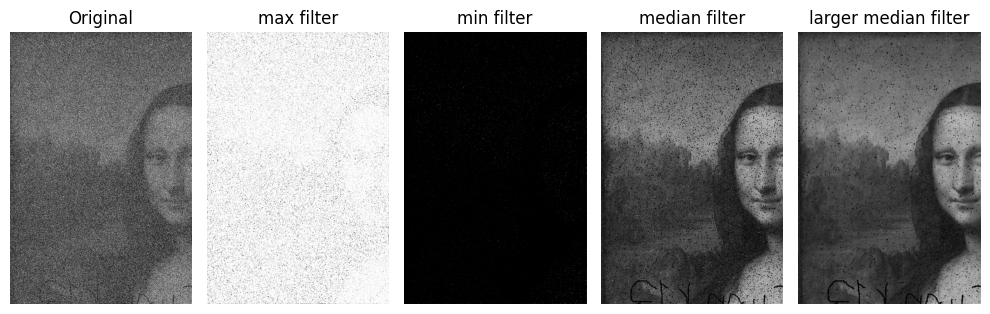

In [39]:
plote_images(
    [img1, img_max, img_min, img_median, img_median_larger],
    titles=["Original", "max filter", "min filter", "median filter", "larger median filter"]
)

In [53]:
def compute_fft_components(image: np.ndarray) -> tuple:
    """
    Compute the FFT components: log-magnitude and phase of a grayscale image.
    Returns normalized versions for display.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    # magnitude = np.log(np.abs(fshift)**2 + 1)
    # magnitude = np.log1p(np.abs(fshift))
    magnitude = 20 * np.log(np.abs(fshift) + 1)
    phase = np.angle(fshift)

    mag_norm = normalize_img(magnitude)
    phase_norm = normalize_img(phase)

    return mag_norm, phase_norm

In [57]:
def normalize_img(img: np.ndarray) -> np.ndarray:
    """
    Normalize image to [0, 1] for visualization.
    """
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

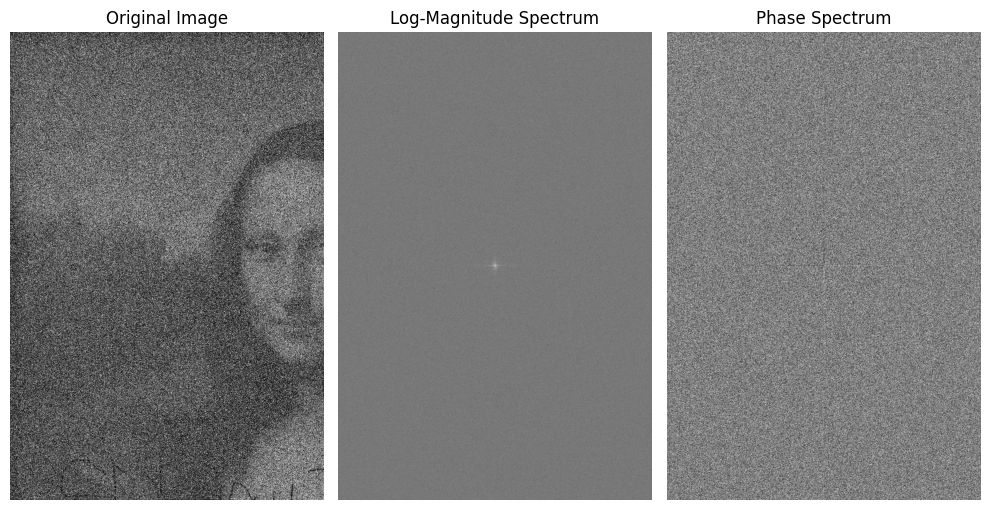

In [45]:
# Compute FFT components
log_mag, phase = compute_fft_components(img1)

# Visualize
plote_images(
    [img1, log_mag, phase],
    titles=["Original Image", "Log-Magnitude Spectrum", "Phase Spectrum"]
)

In [47]:
img_median = denoise_median_filter(img1)
img_median_2 = denoise_median_filter(img_median)
img_median_3 = denoise_median_filter(img_median_2)
img_median_4 = denoise_median_filter(img_median_3)

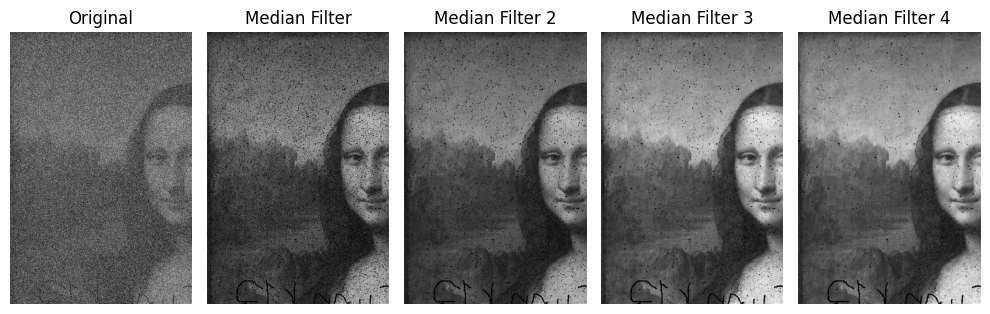

In [49]:
plote_images(
    [img1, img_median, img_median_2, img_median_3, img_median_4],
    titles=["Original", "Median Filter", "Median Filter 2", "Median Filter 3", "Median Filter 4"]
)

In [107]:
median_larger_kernel = denoise_median_filter(img1, ksize = 15)

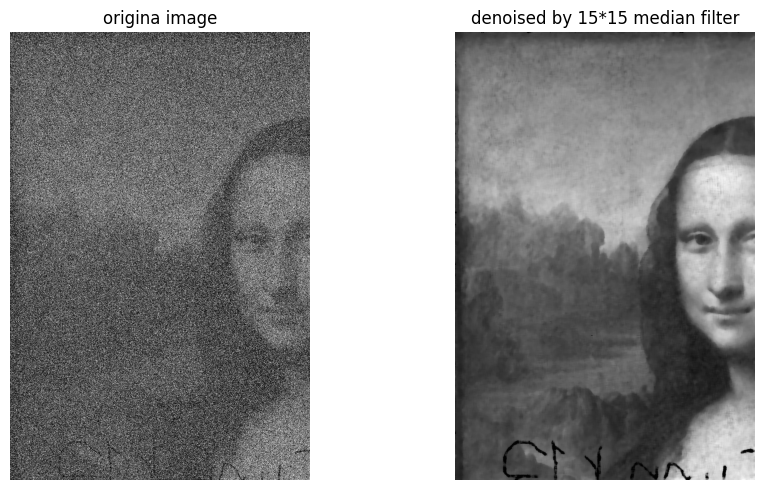

True

In [109]:
plote_images(
    [img1, median_larger_kernel],
    titles=["origina image", "denoised by 15*15 median filter"]
)

cv2.imwrite("img1.png", median_larger_kernel)

---

## image 2: domain change + denoising

In [85]:
import numpy as np

def inverse_fft_image(image: np.ndarray) -> np.ndarray:
    """
    Try to interpret the image as an FFT result (real or magnitude) and apply inverse FFT.
    Returns the magnitude of the spatial-domain image.
    """
    f_ishift = np.fft.ifftshift(image)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)


In [87]:
import pywt

def inverse_wavelet_from_single_band(image: np.ndarray, wavelet: str = 'db1') -> np.ndarray:
    """
    Attempt to reconstruct an image assuming this is a wavelet approximation or detail band.
    Places the band as approximation, zeros for others.
    """
    coeffs = [image, (np.zeros_like(image), np.zeros_like(image), np.zeros_like(image))]  # (cH, cV, cD)
    reconstructed = pywt.waverec2(coeffs, wavelet)
    return reconstructed


In [89]:
def lowpass_reconstruct(image: np.ndarray, radius: int = 30) -> np.ndarray:
    """
    Keeps only low frequencies in the Fourier domain and reconstructs spatial image.
    Useful to check for hidden structure in low frequencies.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    rows, cols = image.shape
    mask = np.zeros((rows, cols), dtype=np.uint8)
    crow, ccol = rows // 2, cols // 2
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

    low_freqs = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(low_freqs))
    return np.abs(img_back)


In [91]:
import matplotlib.pyplot as plt
import cv2

def analyze_domain(image: np.ndarray):
    """
    Plot histogram and gradient to guess the domain of the image.
    """
    sobel = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 1, 1, ksize=3)
    gradient = np.abs(sobel)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.hist(image.ravel(), bins=50)
    plt.title("Pixel Histogram")

    plt.subplot(1, 3, 3)
    plt.imshow(gradient, cmap='gray')
    plt.title("Gradient Magnitude")

    plt.tight_layout()
    plt.show()


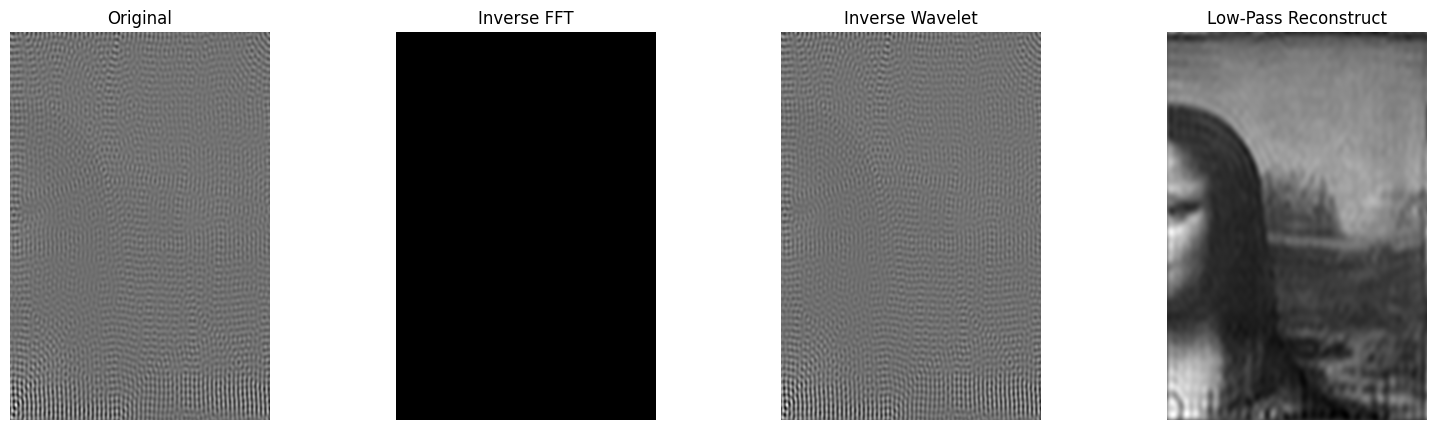

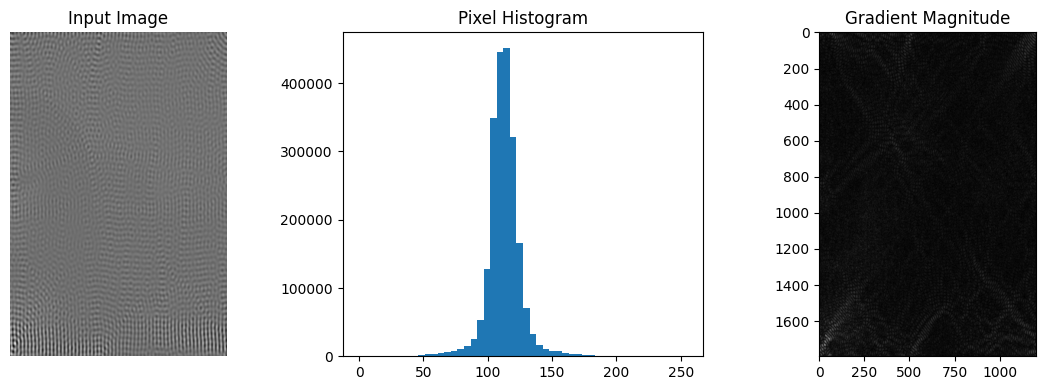

In [93]:
folder = "Q1"
filename = "processed_img_part_2.jpg"
# Load your image
image = load_image("Q1", "processed_img_part_2.jpg")  # use your image loader

# Try inverse FFT
ifft_result = inverse_fft_image(image)

# Try inverse wavelet
iwavelet_result = inverse_wavelet_from_single_band(image)

# Try lowpass Fourier filter
lowpass_result = lowpass_reconstruct(image)

# Visualize all
plote_images(
    [image, ifft_result, iwavelet_result, lowpass_result],
    titles=["Original", "Inverse FFT", "Inverse Wavelet", "Low-Pass Reconstruct"]
)

# Analyze structure
analyze_domain(image)


In [73]:
def load_gray_image(folder: str, filename: str) -> np.ndarray:
    import os
    path = os.path.join(folder, filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {path}")
    return img.astype(np.float32)


In [75]:
def inverse_fft(image: np.ndarray) -> np.ndarray:
    """
    Attempts to interpret the input as a frequency-domain image and reconstruct the spatial domain.
    """
    f_ishift = np.fft.ifftshift(image)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [141]:
def inverse_low_freq_fft(image: np.ndarray, radius: int = 45) -> np.ndarray:
    """
    Applies a low-pass filter in frequency domain, then inverse FFT.
    """
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)

    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros_like(image, dtype=np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 1

    f_filtered = fshift * mask
    img_back = np.fft.ifft2(np.fft.ifftshift(f_filtered))
    return np.abs(img_back)


In [77]:
def inverse_wavelet(image: np.ndarray, wavelet: str = 'db1') -> np.ndarray:
    """
    Tries to treat the input image as a wavelet coefficient band and reconstruct.
    Only works if you actually have a proper wavelet-decomposed structure.
    """
    # We'll treat the entire image as an approximation band and no details
    coeffs = (image, (np.zeros_like(image), np.zeros_like(image), np.zeros_like(image)))
    reconstructed = pywt.waverec2(coeffs, wavelet=wavelet)
    return reconstructed


In [143]:
def plote_images(images: list[np.ndarray], titles: list[str], cmap='gray', max_per_row=4, figsize_per_image=(4, 4)):
    from math import ceil
    n = len(images)
    rows = ceil(n / max_per_row)
    cols = min(n, max_per_row)
    figsize = (figsize_per_image[0]*cols, figsize_per_image[1]*rows*1.1)
    
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


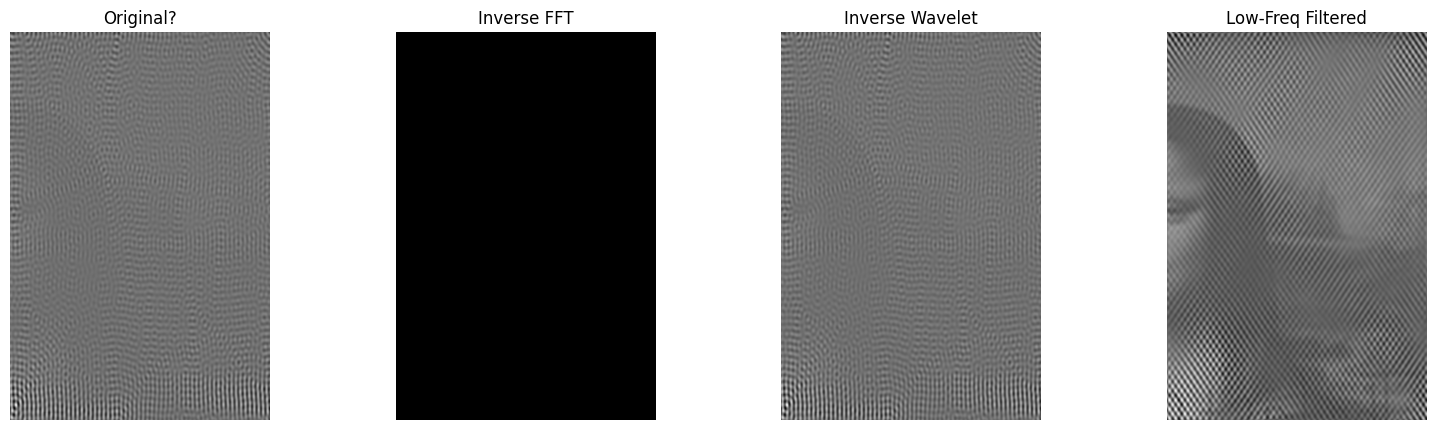

In [145]:
# Try all domains
inv_fft = inverse_fft(image)
inv_wavelet = inverse_wavelet(image)
inv_lowfreq = inverse_low_freq_fft(image)

# Compare
plote_images(
    [image, inv_fft, inv_wavelet, inv_lowfreq],
    ["Original?", "Inverse FFT", "Inverse Wavelet", "Low-Freq Filtered"]
)


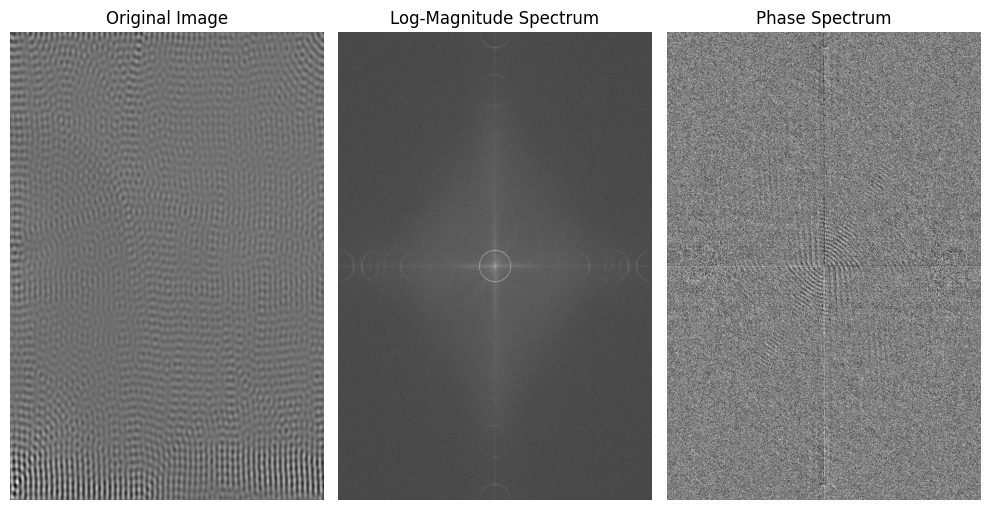

In [161]:
# Compute FFT components
log_mag, phase = compute_fft_components(image)

# Visualize
plote_images(
    [image, log_mag, phase],
    titles=["Original Image", "Log-Magnitude Spectrum", "Phase Spectrum"]
)

In [163]:
def create_band_reject_mask(shape: Tuple[int, int], radius: float, width: float) -> np.ndarray:
    """
    Create a circular band-reject mask for filtering frequencies in FFT domain.
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    Y, X = np.ogrid[:rows, :cols]
    dist = np.sqrt((X - ccol)**2 + (Y - crow)**2)

    # Keep everything except this ring
    mask = np.logical_or(dist <= radius - width/2, dist >= radius + width/2)
    return mask.astype(np.float32)


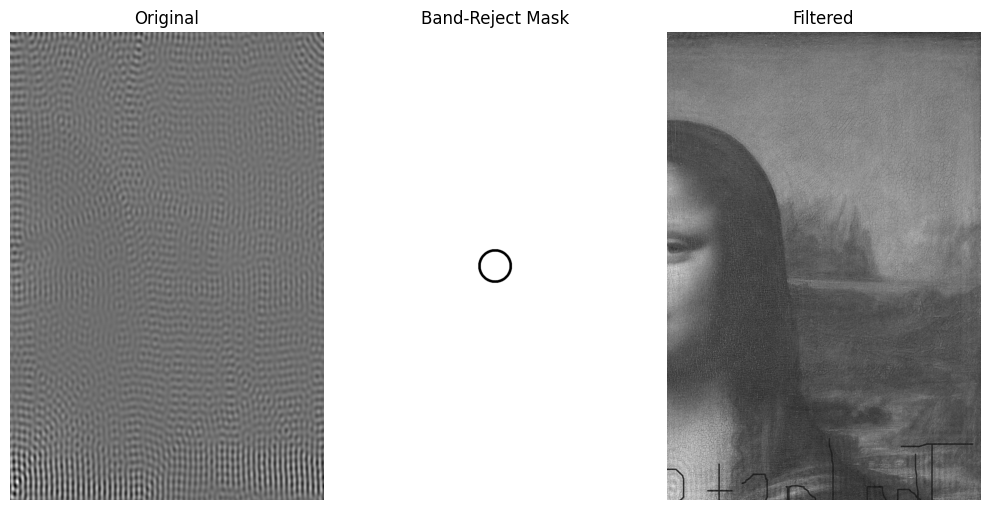

In [165]:
# 1. FFT
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# 2. Mask
mask = create_band_reject_mask(image.shape, radius=60, width=10)
f_filtered = fshift * mask
 
# 3. Inverse FFT
img_back = np.abs(np.fft.ifft2(np.fft.ifftshift(f_filtered)))

# 4. Show results
plote_images([image, mask*255, img_back], ["Original", "Band-Reject Mask", "Filtered"])


---

## image 3: reconstrcution

In [161]:
def plot_laplacian_histograms_normalized(levels, bins=256, range_=(-128, 128), offset=128):
    """
    Plots normalized histograms (PDFs) of Laplacian pyramid levels.

    Parameters:
        levels: list of 2D numpy arrays
        bins: number of histogram bins
        range_: value range for histogram
        offset: offset added during saving (e.g., 128)
    """
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    plt.figure(figsize=(10, 5))

    for i, lvl in enumerate(levels):
        if lvl.dtype == np.uint8:
            data = lvl.astype(np.float32) - offset
        else:
            data = lvl

        # Compute normalized histogram (PDF)
        hist, bin_edges = np.histogram(data.flatten(), bins=bins, range=range_, density=True)
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

        plt.plot(bin_centers, hist, color=colors[i % len(colors)], label=f"Level {i}")

    plt.title("Normalized Laplacian Pyramid Histograms (PDF)")
    plt.xlabel("Residual Value")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True)
    plt.show()


In [41]:
img_level = [None for i in range(5)]
img_level[0] = load_image("Q1", "processed_img_part_3_Level_0.jpg")
img_level[1] = load_image("Q1", "processed_img_part_3_Level_1.jpg")
img_level[2] = load_image("Q1", "processed_img_part_3_Level_2.jpg")
img_level[3] = load_image("Q1", "processed_img_part_3_Level_3.jpg")
img_level[4] = load_image("Q1", "processed_img_part_3_Level_4.jpg")

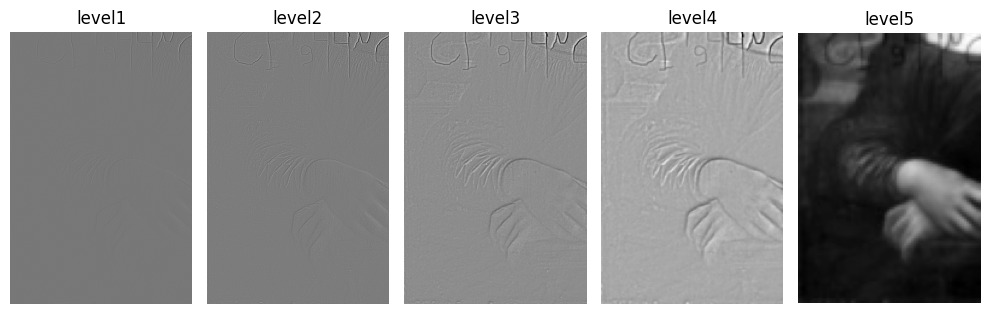

In [43]:
plote_images(
    [img_level[0], img_level[1], img_level[2], img_level[3], img_level[4]],
    titles=["level1", "level2", "level3", "level4", "level5"]
)

In [45]:
sizes = [None for i in range(5)] 
for i in range(5):
    sizes[i] = img_level[i].shape[0], img_level[i].shape[1]

sizes

[(1796, 1201), (898, 601), (449, 301), (225, 151), (113, 76)]

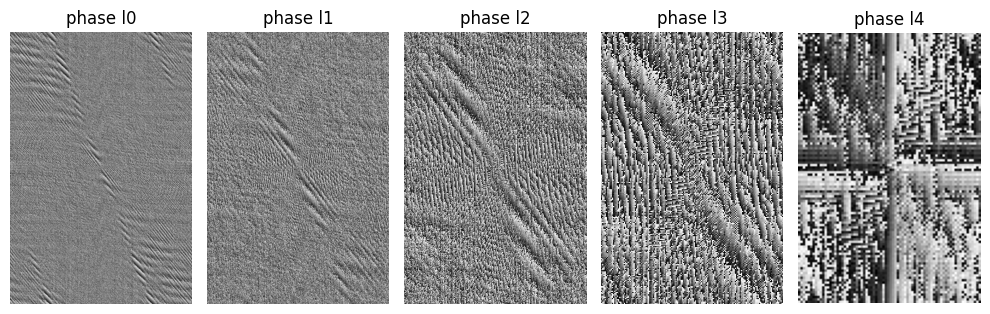

In [139]:
log_img_level = [0 for i in range(5)]
phase_img_level = [0 for i in range(5)]
for i in range(5):
    log_img_level[i], phase_img_level[i] = compute_fft_components(img_level[i])

plote_images(
    [phase_img_level[0], phase_img_level[1], phase_img_level[2], phase_img_level[3], phase_img_level[4]],
    titles=["phase l0", "phase l1", "phase l2", "phase l3", "phase l4"]
)

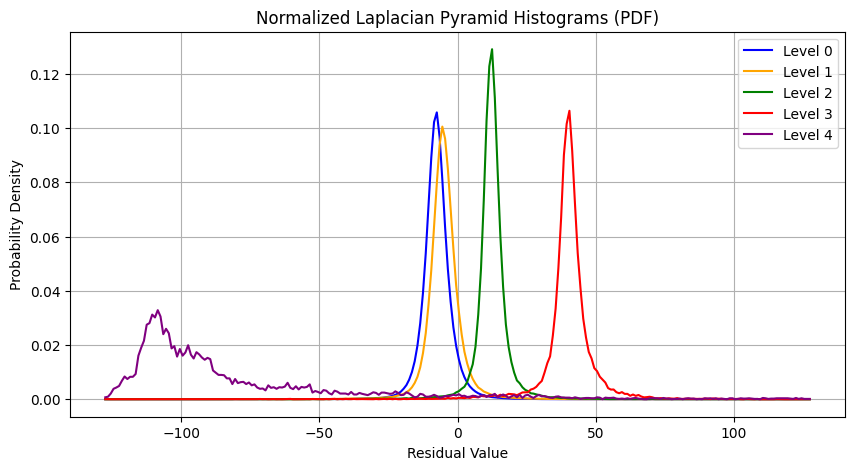

In [131]:
plot_laplacian_histograms_normalized(img_level)

In [151]:
def upsample(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)

def reconstruct_from_pyramid(pyramid_levels):
    reconstructed = pyramid_levels[4]  
    for i in reversed(range(4)):       # Add Level 4 → 3 → 2 → 1 → 0
        print(i)
        up = upsample(reconstructed, pyramid_levels[i].shape)
        reconstructed = up + pyramid_levels[i]
    return reconstructed

In [153]:
reconstructed = reconstruct_from_pyramid(img_level)

3
2
1
0


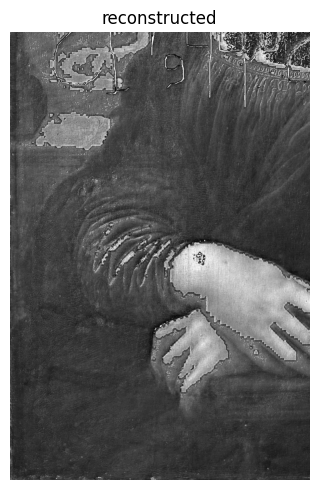

In [155]:
plote_images(
    [reconstructed],
    titles=["reconstructed"]
)

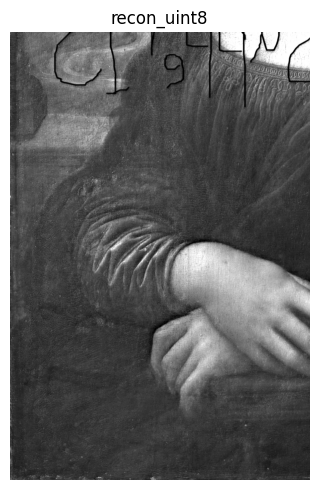

In [163]:
recon = img_level[-1]
for lvl in reversed(levels[:-1]):
    # upsample with bilinear (you could also try other interpolators)
    recon = cv2.resize(recon, (lvl.shape[1], lvl.shape[0]), interpolation=cv2.INTER_LINEAR)
    recon = recon + lvl

# 3) clip back into display range
recon_ = recon
recon_uint8 = np.clip(recon, 0, 255).astype(np.uint8)
# cv2.imwrite("reconstructed_fixed.png", recon_uint8)

plote_images(
    [recon_uint8],
    titles=["recon_uint8"]
)